# TODO
- [x] Soft F1 loss
- [ ] Corregir shift 0.03 en x
- [ ] Aug ofsset y shift hist

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, confusion_matrix
from scipy import signal

import torch
import torch.nn as nn
import torch.nn.functional as f

import fastai2 
from fastai2.data.core import DataLoaders
from fastai2.vision.all import *

print("Pytorch:", torch.__version__)
print("Fastai2:", fastai2.__version__)
print("CUDA:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))

Pytorch: 1.5.0
Fastai2: 0.0.17
CUDA: True
GPU: GeForce GTX 1080 Ti


## Constants

In [2]:
SEED         = 17
HIST_BINS    = 128
BATCH_SIZE   = 4000
EPOCHS       = 3

##### Loss
LABEL_SMOOTH = False
SOFT_F1      = False

### Seed

In [3]:
def seed_everything(seed):
    random.seed(seed)       # Random
    np.random.seed(seed)    # Numpy
    torch.manual_seed(seed) # Pytorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    #tf.random.set_seed(seed) # Tensorflow
    
seed_everything(SEED)

# <center> =========================== DATA ===========================
## Read data

In [4]:
train = pd.read_csv('data/train_clean.csv', dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int64})
test  = pd.read_csv('data/test_clean.csv',  dtype={'time': np.float32, 'signal': np.float32})
sub   = pd.read_csv('data/sample_submission.csv', dtype={'time': np.float32})

# FEATURES
train["signal"] = np.load('data/0_x_train.npy')
test["signal"]  = np.load('data/0_x_test.npy')
train["group"]  = np.load("data/0_groups_train.npy")
test["group"]   = np.load("data/0_groups_test.npy")

#train["preds"] = np.load("data/1_linear_preds_train.npy")
#test["preds"]  = np.load("data/1_linear_preds_test.npy")

#train["noise"] = np.load("data/2_noise_train.npy")
#test["noise"]  = np.load("data/2_noise_test.npy")

train["x_sin_50hz"] = np.float32(np.load("data/3_x_sin_50hz_train.npy"))
test["x_sin_50hz"]  = np.float32(np.load("data/3_x_sin_50hz_test.npy"))

train["x_sin_freqs"] = np.load("data/3_x_without_freqs_linPred_train.npy")
test["x_sin_freqs"]  = np.load("data/3_x_without_freqs_linPred_test.npy")



#train_signal = np.float32(np.load("data/train_x_without50hz.npy"))
#test["signal"] = np.float32(np.load("data/test_x_without50hz.npy"))
test["open_channels"] = 0 # CHAPUZA para ahorrar codigo

In [5]:
train.head()

,time,signal,open_channels,group,x_sin_50hz,x_sin_freqs
0,0.0001,-2.7600,0,0,-2.708945,-2.704058
1,0.0002,-2.8557,0,0,-2.804274,-2.799828
2,0.0003,-2.4074,0,0,-2.355654,-2.351915
3,0.0004,-3.1404,0,0,-3.088385,-3.085588
4,0.0005,-3.1525,0,0,-3.100266,-3.098599


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           float32
 1   signal         float32
 2   open_channels  int64  
 3   group          int64  
 4   x_sin_50hz     float32
 5   x_sin_freqs    float32
dtypes: float32(4), int64(2)
memory usage: 152.6 MB


In [7]:
train_gr1 = pd.concat([train[      0: 500000], train[ 500000:1000000]])
train_gr2 = pd.concat([train[1000000:1500000], train[3000000:3500000]])
train_gr3 = pd.concat([train[1500000:2000000], train[3500000:4000000]])
train_gr4 = pd.concat([train[2500000:3000000], train[4000000:4500000]])
train_gr5 = pd.concat([train[2000000:2500000], train[4500000:5000000]])

In [8]:
train_for_test = pd.concat([train_gr1[:-1000000],
                            train_gr2[:-100000],
                            train_gr3[:-200000],
                            train_gr4[:-200000],
                            train_gr5[:-200000]])

valid_like_test = pd.concat([train_gr1[-1000000:],
                             train_gr2[-100000:],
                             train_gr3[-200000:],
                             train_gr4[-200000:],
                             train_gr5[-200000:]])

# Dataset
- Poner onhot grupo en entrada
- Agumatation
  - Leer a la inversa

In [9]:
class DS(torch.utils.data.Dataset):
    def __init__(self, df, win_size=9):
        
        num_segments = len(df) // 100000
        
        self.x_orig = np.split(df["signal"].values, num_segments)
        #self.hists = [torch.tensor(np.histogram(x, bins=256, range=(-5.5096, 8.402788))) for x in self.x_orig]
        self.x_orig = [torch.tensor(np.pad(x, pad_width=win_size//2, mode='edge')) for x in self.x_orig]
        
        self.x_50hz = np.split(df["x_sin_50hz"].values, num_segments)
        self.hists  = [torch.tensor(np.histogram(x, bins=HIST_BINS, range=(-5.5096, 8.402788), density=True)[0], dtype=torch.float) for x in self.x_50hz]
        self.x_50hz = [torch.tensor(np.pad(x, pad_width=win_size//2, mode='edge')) for x in self.x_50hz]
        
        self.x_clean = np.split(df["x_sin_50hz"].values, num_segments)
        #self.hists  = [torch.tensor(np.histogram(x, bins=256, range=(-5.5096, 8.402788))) for x in self.x_clean]
        self.x_clean = [torch.tensor(np.pad(x, pad_width=win_size//2, mode='edge')) for x in self.x_clean]
        
        self.feats    = [torch.stack((f1, f2), dim=1) for (f1,f2) in zip(self.x_50hz, self.x_clean)]
       
        self.y        = torch.tensor(df["open_channels"].values, dtype=torch.long)
        
        self.win_size   = win_size
        
        #_x         = torch.tensor(np.pad(df["signal"].values,      pad_width=win_size//2, mode='edge'))
        #_x_50hz    = torch.tensor(np.pad(df["x_sin_50hz"].values, pad_width=win_size//2, mode='edge'))
        #_x_clean   = torch.tensor(np.pad(df["x_sin_freqs"].values, pad_width=win_size//2, mode='edge'))
        #_50hz     = torch.tensor(np.pad(df["50hz"].values,       pad_width=win_size//2, mode='edge'))
        #_noise    = torch.tensor(np.pad(df["noise"].values,      pad_width=win_size//2, mode='edge'))
        #self._group = torch.tensor(np.pad(df["group"].values, pad_width=win_size//2, mode='edge'))
        #_g_oh       = F.one_hot(self._group, num_classes=5).float()
        #xfeats     = torch.stack((_x_50hz, _x_clean), dim=1)#.float() #_x_50hz.unsqueeze(0)
        #self.feats = torch.cat([xfeats, _g_oh], dim=1)
        #self.scalogram = signal.cwt(data=df["signal"].values, wavelet=signal.ricker, widths=np.arange(1, 31))
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):
        
        segment   = i // 100000
        segment_i = i % 100000
        
        window = self.feats[segment][segment_i:segment_i+self.win_size]
        hist   = self.hists[segment]
        y      = self.y[i]
        
        #group     = torch.tensor(self._group[i],  dtype=torch.int64)
        #group_oh  = F.one_hot(group, num_classes=5).float()
        #scalogram = torch.tensor(self.scalogram[:,i]).float() # array of 30
        #x = torch.cat([group_oh, window]) # scalogram
        
        return ((window.T,hist), y)

In [10]:
#g5toy_train = DS(train4[:100000], win_size=9)
#g5toy_valid = DS(train9[:100000], win_size=9)
#
#g5big_train = DS(train4, win_size=9)
#g5big_valid = DS(train9, win_size=9)
#
#m = 10000
#toy_train = DS(pd.concat([train0[:m], train2[:m], train7[:m], train5[:m], train4[:m]]), win_size=9)
#toy_valid = DS(pd.concat([train1[:m], train6[:m], train3[:m], train8[:m], train9[:m]]), win_size=9)
#
#half_train = DS(pd.concat([train0, train2, train7, train5, train9]), win_size=9)
#half_valid = DS(pd.concat([train1, train6, train3, train8, train4]), win_size=9)
#
#all_train = DS(train, win_size=9)
#
#test_ds  = DS(test, win_size=9)
#
#BS = 256 # 256, 512
#dls_g5toy = DataLoaders.from_dsets(g5toy_train, g5toy_valid, test_ds, bs=BS, device=torch.device("cuda"))
#dls_g5big = DataLoaders.from_dsets(g5big_train, g5big_valid, test_ds, bs=BS, device=torch.device("cuda"))
#dls_toy   = DataLoaders.from_dsets(toy_train,   toy_valid,   test_ds, bs=BS, device=torch.device("cuda"))
#dls_half  = DataLoaders.from_dsets(half_train,  half_valid,  test_ds, bs=4000, device=torch.device("cuda"))
#dls_all   = DataLoaders.from_dsets(all_train,   toy_valid,   test_ds, bs=3000, device=torch.device("cuda"))

## DataLoaders

In [11]:
dl_g5toy = DataLoaders.from_dsets(DS(train_gr5[:100000]),DS(train_gr5[100000:200000]), bs=BATCH_SIZE, device="cuda")
dl     = DataLoaders.from_dsets(DS(train_for_test), DS(valid_like_test), DS(test), bs=BATCH_SIZE, device="cuda")
dl_all = DataLoaders.from_dsets(DS(train), DS(train[:100000]), DS(test), bs=BATCH_SIZE, device="cuda")

# <center> =========================== MODEL ===========================
## Net 9

In [12]:
64+48+32+24+16

184

In [13]:
# TODO: ReLU , BatchNorm, Dropout

class Net9(nn.Module):
    def __init__(self, win_feats=2):
        super(Net9, self).__init__()
        
        ################### FEATURE EXTRACTOR: 64+48+32+24+16 = 184 feats
        self.li = nn.Linear(in_features=win_feats,  out_features=16)
        self.bn0 = nn.BatchNorm1d(win_feats)
        self.c1  = nn.Conv1d(in_channels=win_feats,  out_channels=64, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.c2  = nn.Conv1d(in_channels=64, out_channels=48, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(48)
        self.c3  = nn.Conv1d(in_channels=48, out_channels=32, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(32)
        self.c4  = nn.Conv1d(in_channels=32, out_channels=24,  kernel_size=3);
        self.bn4 = nn.BatchNorm1d(24)
        self.relu = nn.ReLU()
        
        self.hist = nn.Sequential(
            nn.Linear(HIST_BINS   , HIST_BINS*4), nn.ReLU(),
            nn.Linear(HIST_BINS*4 , HIST_BINS*2), nn.ReLU(),
            nn.Linear(HIST_BINS*2 , 32)         , nn.ReLU())
                
        self.classifier = nn.Sequential(
            nn.Linear((184+32), 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(p=0.1),
            nn.Linear(512,      256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(p=0.1),
            nn.Linear(256,      64),  nn.BatchNorm1d(64),  nn.ReLU(), nn.Dropout(p=0.1),
            nn.Linear(64,       11))
        
    def forward(self, x): # window=(BS, c=2, L=9) hist=(BS, 256)
        
        window, hist = x
        
        ################### FEATURE EXTRACTOR
        
        #window = self.bn0(window)
        c1_res = self.bn1(self.c1(window))
        c2_res = self.bn2(self.c2(self.relu(c1_res)))
        c3_res = self.bn3(self.c3(self.relu(c2_res)))
        c4_res = self.c4(self.relu(c3_res))
        
        li_final = self.li(window[:,:,4])  # 16 feats
        c1_final = c1_res[:,:,3:-3].squeeze(2) # 32 feats
        c2_final = c2_res[:,:,2:-2].squeeze(2) # 32 feats
        c3_final = c3_res[:,:,1:-1].squeeze(2) # 32 feats       
        c4_final = c4_res.squeeze(2)           # 32 feats
        
        hist = self.hist(hist)
        
        # 101 feats:  16 (li) + 64 (cnn1) + 24 (cnn2) + 16 (cnn3) + 8 (cnn4)
        #print(group_oh.shape, li_final.shape, c1_final.shape, c2_final.shape, c3_final.shape, c4_final.shape)
        feats = torch.cat([hist, li_final, c1_final, c2_final, c3_final, c4_final], dim=1)
        #print(feats.shape)
        
        ################### CLASSIFIER
        return self.classifier(feats)
            
net9 = Net9(win_feats=2)

In [14]:
x = dl.dataset[0][0]
net9.eval()
net9((x[0].unsqueeze(0), x[1].unsqueeze(0)))
#net9(x)
net9.train();

# <center> =========================== LOSS ===========================
- CE
- Weigted CE
- Negibour Label Smoothing CE
- Focal
- SoftF1

## Weigted class loss

In [13]:
dls         = dls_half, # dls_toy, dls_half, dls_g5toy, dls_g5big
train_preds = dls[0].array_y

AttributeError: 'DS' object has no attribute 'array_y'

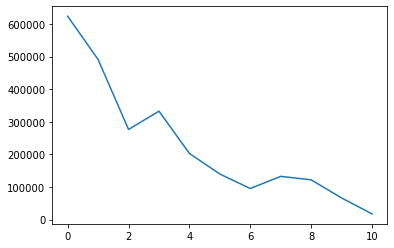

In [13]:
plt.plot(np.bincount(train_preds));

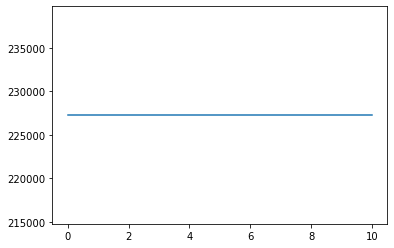

In [14]:
class_weights = np.bincount(train_preds).sum() / (11 * np.bincount(train_preds))
plt.plot(np.bincount(train_preds) * class_weights);

In [15]:
class_weights=torch.FloatTensor(class_weights).cuda()

RuntimeError: cuda runtime error (999) : unknown error at ../aten/src/THC/THCGeneral.cpp:47

## Neighbour Label Smoothing loss

In [16]:
class SmartLabelSmoothingCE(Module):
    def __init__(self, label_smoothing:float=0.0): 
        self.label_smoothing = Tensor([
            [0,1,0,0,0,0,0,0,0,0,0],
            [1,0,1,0,0,0,0,0,0,0,0],
            [0,1,0,1,0,0,0,0,0,0,0],
            [0,0,1,0,1,0,0,0,0,0,0],
            [0,0,0,1,0,1,0,0,0,0,0],
            [0,0,0,0,1,0,1,0,0,0,0],
            [0,0,0,0,0,1,0,1,0,0,0],
            [0,0,0,0,0,0,1,0,1,0,0],
            [0,0,0,0,0,0,0,1,0,1,0],
            [0,0,0,0,0,0,0,0,1,0,1],
            [0,0,0,0,0,0,0,0,0,1,0],
        ])
        self.label_smoothing  *= (label_smoothing / self.label_smoothing.sum(dim=1,keepdims=True))
        self.label_smoothing += (1-label_smoothing) * torch.eye(11)

    def forward(self, logits, true):
        n_classes = logits.size()[-1]
        y_pred = logits.view(-1,n_classes)    
        y_true = self.label_smoothing[true.flatten()].view(-1,n_classes).to(logits.device)
        return (- y_true * F.log_softmax(y_pred, dim=1)).sum(dim=1).mean()

## Soft F1 Loss

In [17]:
def softf1_loss(logits,true,weights=None):
    eps=0
    # 96 4000 11, 96 4000 1 
    n_classes = logits.shape[-1]
    weights = ifnone(weights,torch.ones((n_classes,),dtype=logits.dtype,device=logits.device))
    y_pred = logits.view(-1,n_classes).softmax(dim=-1)             
    y_true = F.one_hot(true.flatten(), n_classes).to(torch.float32)

    tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

    precision = tp / (tp + fp + eps )
    recall = tp / (tp + fn + eps )

    f1 = 2* (precision*recall) / (precision + recall + eps)
    f1 = f1.clamp(0,1) * weights
    f1 = f1[~torch.isnan(f1)].mean()
    return 1-f1

## CE + SoftF1 Loss

In [18]:
class CE_F1_loss(Module):
    def forward(self, out, targ):
        self.ce = F.cross_entropy(out, targ)
        self.f1 = softf1_loss(out, targ)
        return self.ce + self.f1

In [19]:
if LABEL_SMOOTH:
    loss = SmartLabelSmoothingCE(0.1)
elif SOFT_F1:
    loss = CE_F1_loss()
else:
    loss = nn.CrossEntropyLoss(weight=None)

# <center> =========================== TRAIN ===========================

## Callbacks

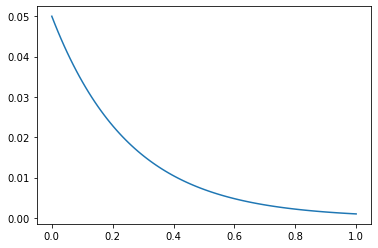

In [22]:
x = torch.linspace(0.,1,100); plt.plot(x, SchedExp(0.05, 0.001)(x));

In [23]:
class DynamicAugmentation(Callback):
    def __init__(self):
        self.sch = SchedExp(0.05, 0.001)
        
    def begin_batch(self):
        if self.training:
            dynamic_factor = self.sch(self.pct_train) # 1 at the begining, 0 at the end

            # Get batch
            windows = self.learn.x[0]
            hists   = self.learn.x[1]

            # Generate noise
            windows_noise = torch.randn(size=windows.shape, device=windows.device)  # [-1, 1]
            windows_noise *= dynamic_factor # MAX: [-0.05, 0.05]

            # Apply noise
            windows.add_(windows_noise) # Inplace modification

        return True

## Learner

In [24]:
# TODO: Weighted by class
# TODO: Better loss for F1 macro??? Focal??
# TODO: Adam, Radam,...
learn = Learner(dls       = dl_all, #dl, # dl_all dl, #dls_half, dls_g5big, dls_g5toy, dls_g5, dls
                model     = net9.cuda(),
                loss_func = loss,
                metrics   = [F1Score(average='macro'), accuracy],
                cbs       = [ShowGraphCallback(), DynamicAugmentation()])
#learn.summary()

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.019054606556892395)

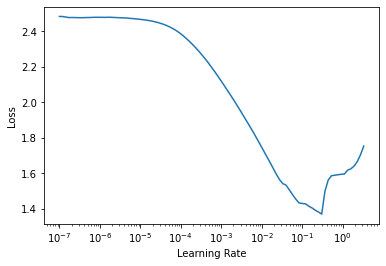

In [25]:
learn.lr_find()

In [23]:
10e-2

0.1

# Data:All Feats:x_50 dynamicAug

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.103324,0.001413,0.663494,0.999560,02:15
1,0.092192,0.001653,0.994666,0.999500,02:17
2,0.084283,0.000889,0.996781,0.999700,02:15


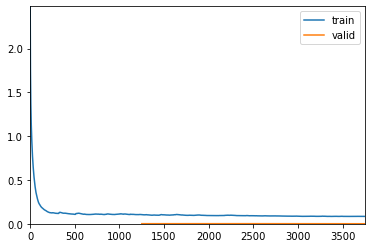

In [27]:
learn.fit_one_cycle(n_epoch=EPOCHS, lr_max=0.1)

# DL like test. FEATS x_50 with dynamicAug 3 EPOCHS BS 2048

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.130797,0.144941,0.884707,0.953320,02:07
1,0.115582,0.074323,0.928941,0.976028,02:04
2,0.104821,0.072541,0.940404,0.979682,02:05


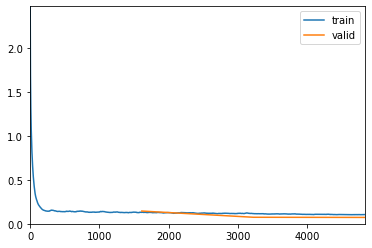

In [24]:
learn.fit_one_cycle(n_epoch=EPOCHS, lr_max=0.1)

# DL like test. FEATS x_50 with dynamicAug 10 EPOCHS BS 4000

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.119371,0.057707,0.916210,0.977490,02:02
1,0.121643,0.441758,0.822859,0.852761,02:04
2,0.116921,0.058163,0.937031,0.979946,02:07
3,0.111543,0.184352,0.912589,0.931485,02:03
4,0.112227,0.050493,0.934988,0.981024,02:02
5,0.108937,0.050167,0.938998,0.981387,02:04
6,0.105116,0.058783,0.932519,0.978621,02:07
7,0.103926,0.061157,0.930628,0.978239,02:04
8,0.101534,0.051520,0.941099,0.981541,02:04
9,0.100215,0.052047,0.940763,0.981111,02:04


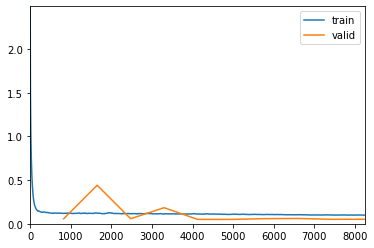

In [24]:
learn.fit_one_cycle(n_epoch=EPOCHS, lr_max=0.1)

# DL like test. FEATS x_50 with dynamicAug SOFTF1

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.223491,0.143702,0.908488,0.974834,02:04
1,0.204120,0.165382,0.924963,0.972714,02:04
2,0.186755,0.100439,0.941346,0.981515,02:02


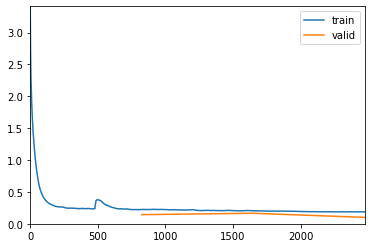

In [26]:
learn.fit_one_cycle(n_epoch=3, lr_max=0.1)

# DL like test. FEATS x_50 with dynamicAug

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.121471,0.054670,0.938500,0.980009,02:03
1,0.111490,0.220449,0.917936,0.968678,02:02
2,0.101616,0.047638,0.941908,0.982072,02:04


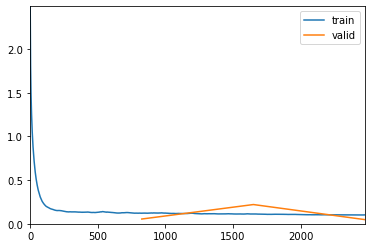

In [23]:
learn.fit_one_cycle(n_epoch=3, lr_max=0.1)

# DL like test. FEATS x_50

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.122400,0.055872,0.924730,0.978601,02:06
1,0.111329,0.052646,0.931147,0.980153,02:10
2,0.101829,0.047931,0.941689,0.981818,02:05


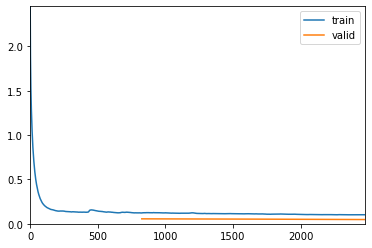

In [17]:
learn.fit_one_cycle(n_epoch=3, lr_max=0.1)

# DL like test. FEATS x_50, x_allfreqs

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.121464,0.052849,0.935615,0.980001,02:07
1,0.111154,0.064461,0.909369,0.975784,02:11
2,0.101486,0.050408,0.941401,0.981481,02:08


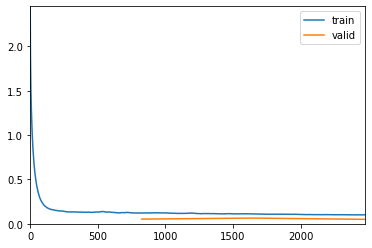

In [17]:
learn.fit_one_cycle(n_epoch=3, lr_max=0.1)

In [16]:
#learn.fit_one_cycle(n_epoch=6, lr_max=0.05)

In [30]:
#learn.save("net9_all_6eps_lr5e-2")

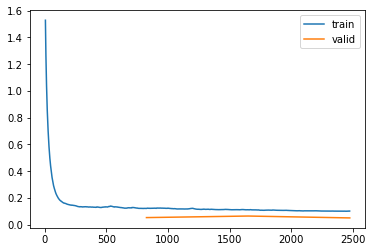

In [19]:
learn.recorder.plot_loss()

# <center> TRAIN CrossVal & Staking

In [ ]:
val_pct = []
tst_preds = []
skf = StratifiedKFold(n_splits=10, shuffle=True)

for _, val_idx in skf.split(np.array(train_imgs), train_labels):
    
    splits = IndexSplitter(val_idx)
    split = splits(train_imgs)
    split_list = [split[0], split[1]]
    split_list.append(L(range(len(train_imgs), len(train_imgs)+len(tst_imgs))))
    dsrc = Datasets(train_imgs+tst_imgs, tfms=[[PILImage.create], [parent_label, Categorize]],
                  splits=split_list)
    dls = dsrc.dataloaders(bs=bs, after_item=item_tfms, after_batch=batch_tfms)
    learn = cnn_learner(dls, resnet34, pretrained=False, metrics=accuracy)
    learn.fit_one_cycle(1)
    val_pct.append(learn.validate()[1])
    a,b = learn.get_preds(ds_idx=2)
    tst_preds.append(a)

# Validación

In [18]:
#interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [19]:
preds,targs = learn.get_preds()

preds = torch.max(preds, 1)[1].numpy()
targs = targs.numpy()
len(preds)

1700000

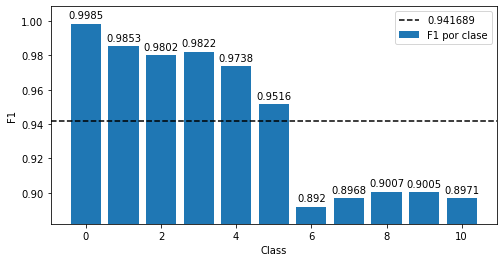

In [20]:
f1 = f1_score(preds, targs, average=None)

plt.figure(figsize=(8, 4))
plt.ylim([min(f1)-0.01, max(f1)+0.01])
plot = plt.bar(list(range(0,11)), f1)
plt.axhline(f1.mean(), color='k', linestyle='--')

for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2., 1.002*height,round(height,4), ha='center', va='bottom')

plt.xlabel("Class")
plt.ylabel("F1")
plt.legend([str(round(f1.mean(),6)),"F1 por clase"])
plt.show()

# DL like test. FEATS x_50, x_allfreqs

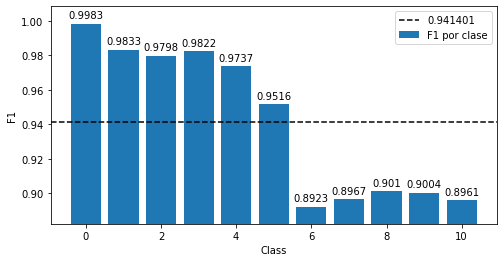

In [22]:
f1 = f1_score(preds, targs, average=None)

plt.figure(figsize=(8, 4))
plt.ylim([min(f1)-0.01, max(f1)+0.01])
plot = plt.bar(list(range(0,11)), f1)
plt.axhline(f1.mean(), color='k', linestyle='--')

for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2., 1.002*height,round(height,4), ha='center', va='bottom')

plt.xlabel("Class")
plt.ylabel("F1")
plt.legend([str(round(f1.mean(),6)),"F1 por clase"])
plt.show()

In [27]:
preds_df = pd.DataFrame({'preds': preds, 'targs': targs})

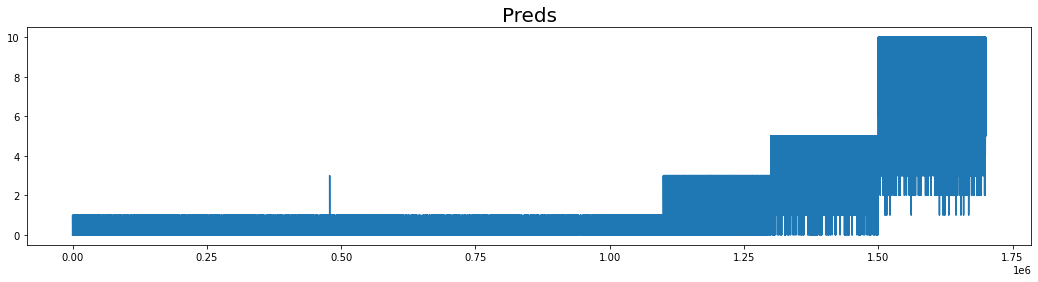

In [21]:
plt.figure(figsize=(18, 4)); plt.plot(preds); plt.title("Preds",fontsize=20);

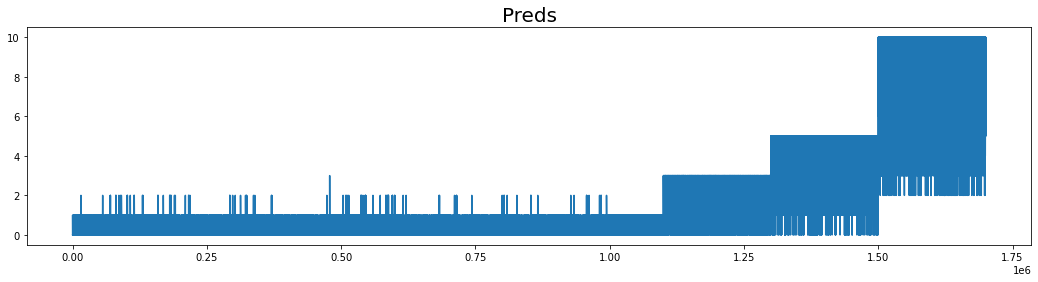

In [23]:
plt.figure(figsize=(18, 4)); plt.plot(preds); plt.title("Preds",fontsize=20);

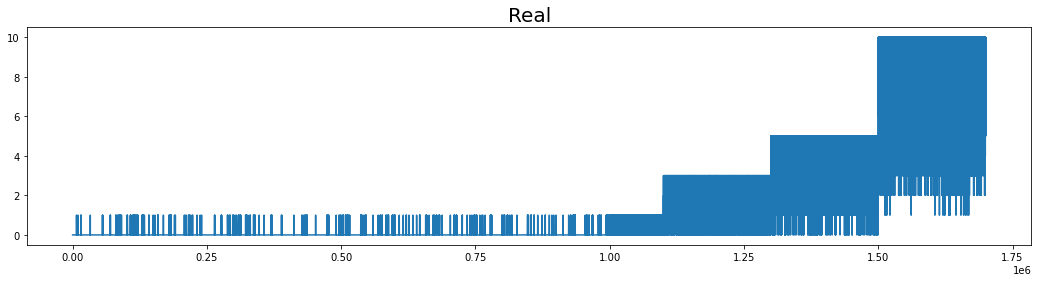

In [24]:
plt.figure(figsize=(18, 4)); plt.plot(targs); plt.title("Real",fontsize=20);

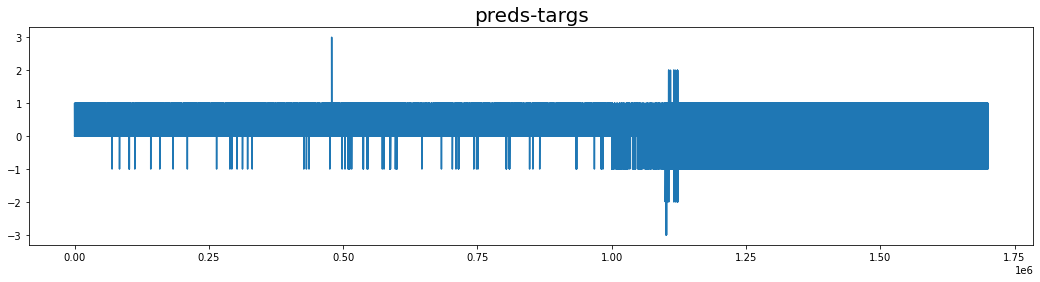

In [25]:
plt.figure(figsize=(18, 4)); plt.plot(preds-targs); plt.title("preds-targs",fontsize=20);

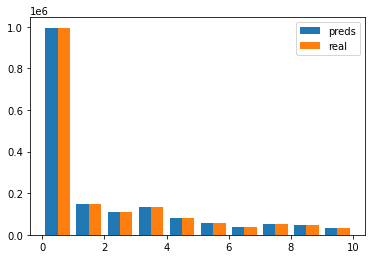

In [32]:
plt.hist([preds, targs], label=['preds', 'real'])
plt.legend(loc='upper right')
plt.show()

In [33]:
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, confusion_matrix

print("Accuracy:    ", accuracy_score(preds, targs))
print("Balanced acc:", balanced_accuracy_score(preds, targs))
print("F1 score:    ", f1_score(preds, targs, average='macro'))
print("Confus mat:\n", confusion_matrix(preds, targs))

Accuracy:     0.9827029411764706
Balanced acc: 0.9433512351036787
F1 score:     0.9419993344023823
Confus mat:
 [[994801    765      7      0      0      0      0      0      0      0
       0]
 [   478 147772    650     23      0      0      0      0      0      0
       0]
 [     7    912 109049   1503      0      0      0      0      0      0
       0]
 [     0     18   1360 131365   1074      0      0      0      0      0
       0]
 [     0      0      0    837  78523   1224      0      0      0      0
       0]
 [     0      0      0      0   1200  53125   1447      0      0      0
       0]
 [     0      0      0      0      0   1535  33833   2602      0      0
       0]
 [     0      0      0      0      0      0   2622  47821   3228      0
       0]
 [     0      0      0      0      0      0      0   2591  44326   2049
       0]
 [     2      0      0      0      0      0      0      0   1863  23907
     824]
 [     0      0      0      0      0      0      0      0      0    

In [28]:
ran = len(preds) // 5

print("Gr 1 F1", f1_score(preds[ran*0:ran*1], targs[ran*0:ran*1], average='macro'))
print("Gr 2 F1", f1_score(preds[ran*1:ran*2], targs[ran*1:ran*2], average='macro'))
print("Gr 3 F1", f1_score(preds[ran*2:ran*3], targs[ran*2:ran*3], average='macro'))
print("Gr 4 F1", f1_score(preds[ran*3:ran*4], targs[ran*3:ran*4], average='macro'))
print("Gr 5 F1", f1_score(preds[ran*4:ran*5], targs[ran*4:ran*5], average='macro'))

Gr 1 F1 0.6639813194446448
Gr 2 F1 0.9966595700013653
Gr 3 F1 0.9864116010265567
Gr 4 F1 0.9733168456644817
Gr 5 F1 0.7267555866969556


# Test

In [28]:
preds_t,targs_t = learn.get_preds(ds_idx=2)

preds_t = torch.max(preds_t, 1)[1].numpy()
#targs_t.numpy()
preds_t

array([0, 0, 0, ..., 0, 0, 0])

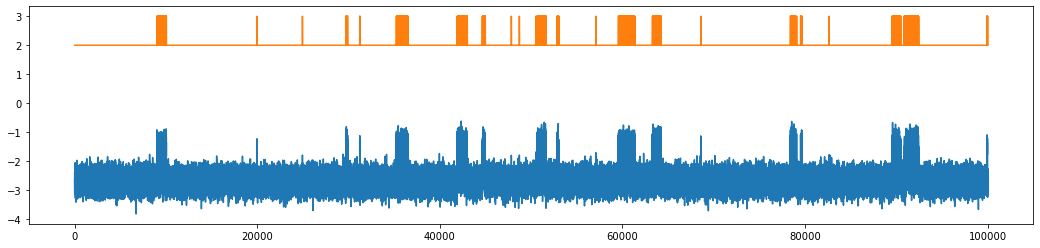

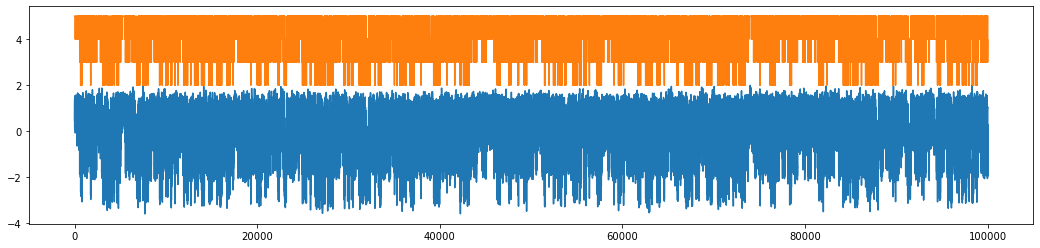

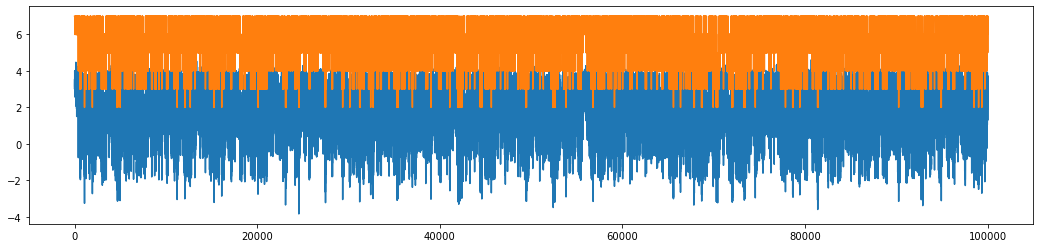

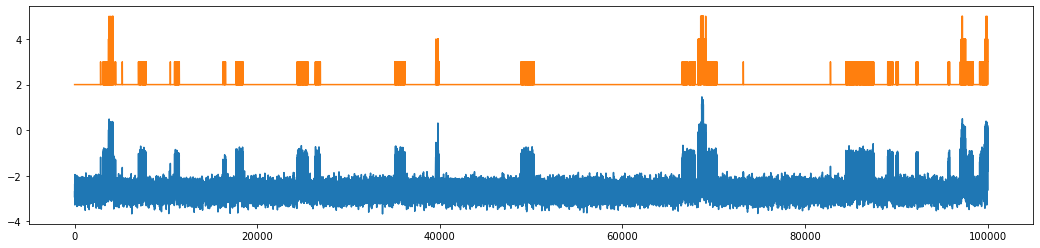

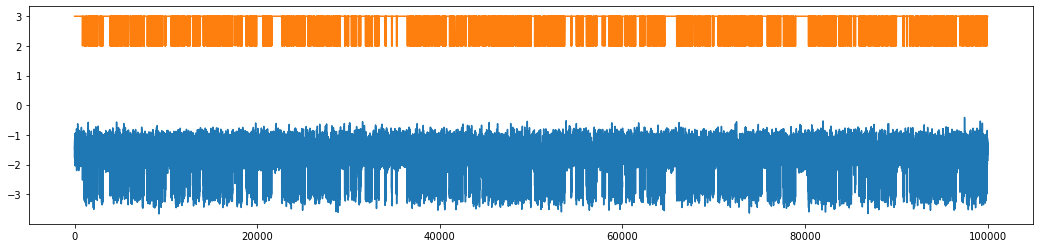

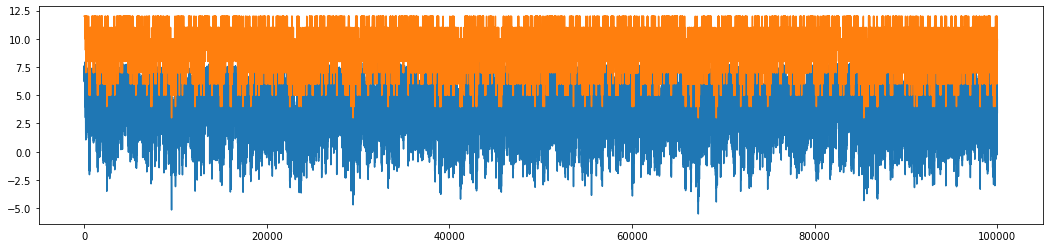

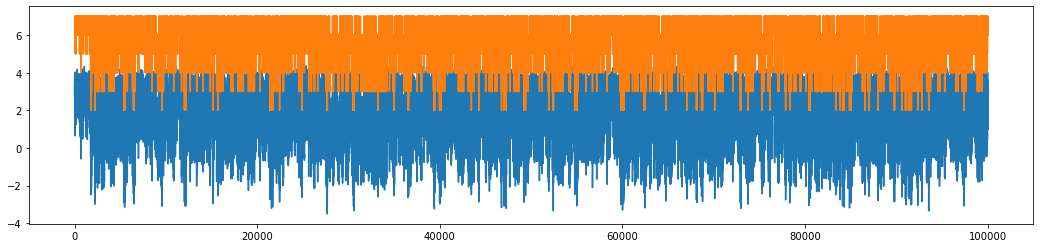

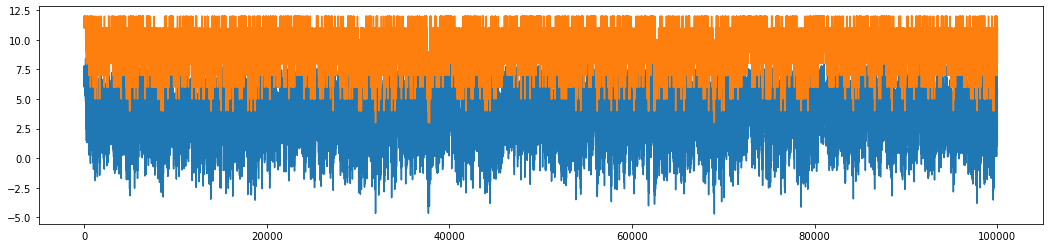

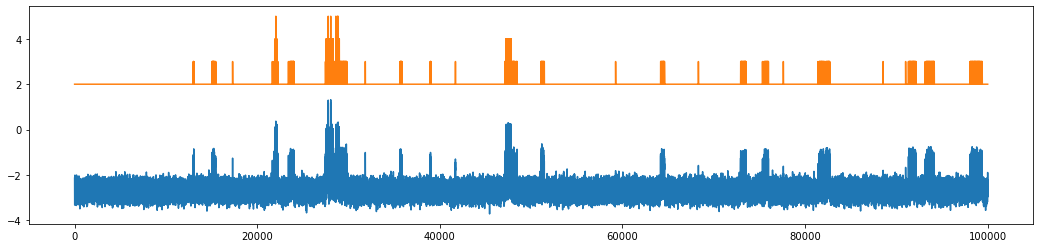

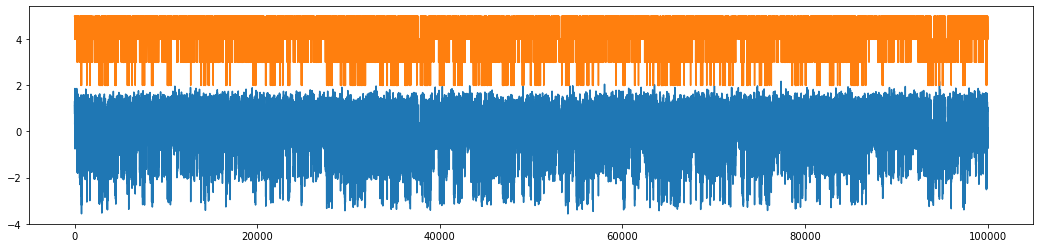

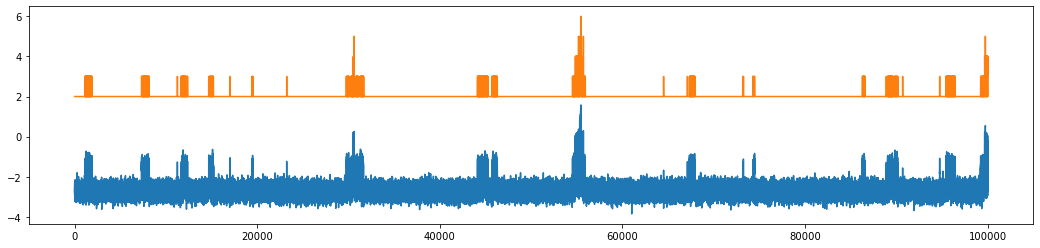

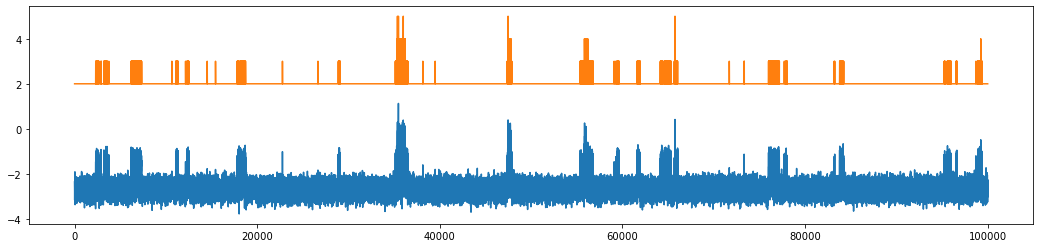

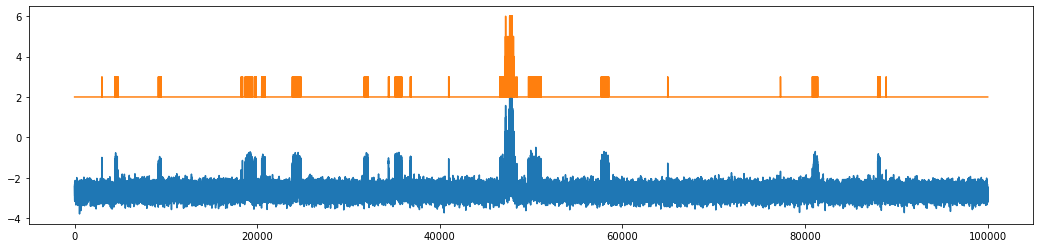

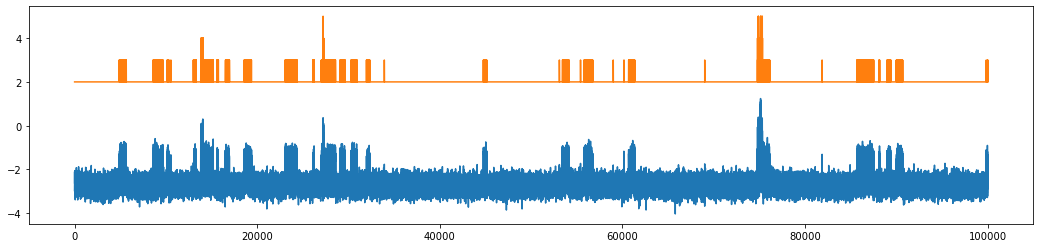

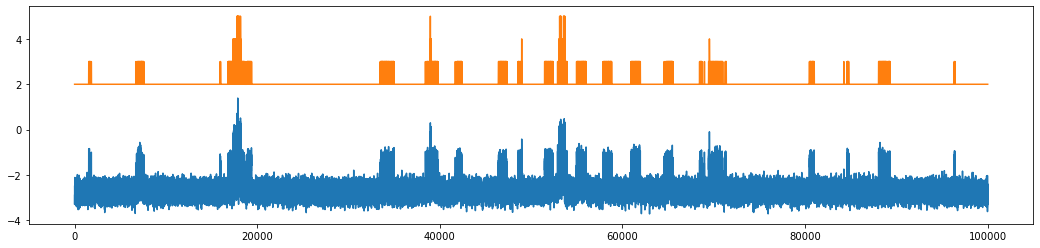

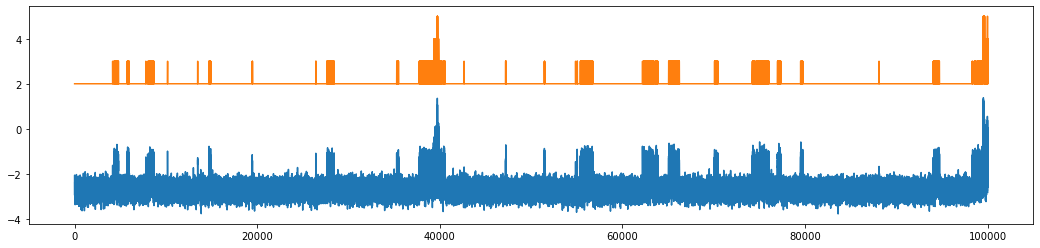

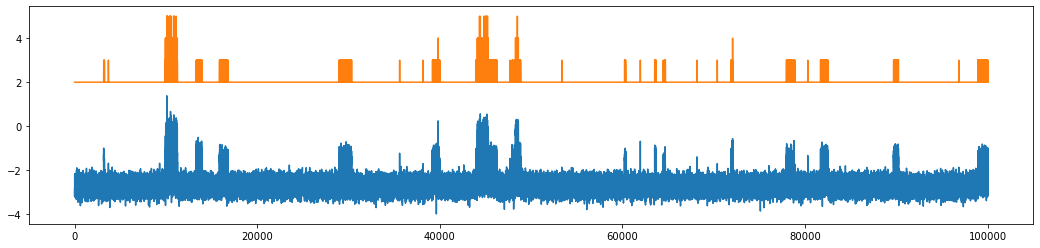

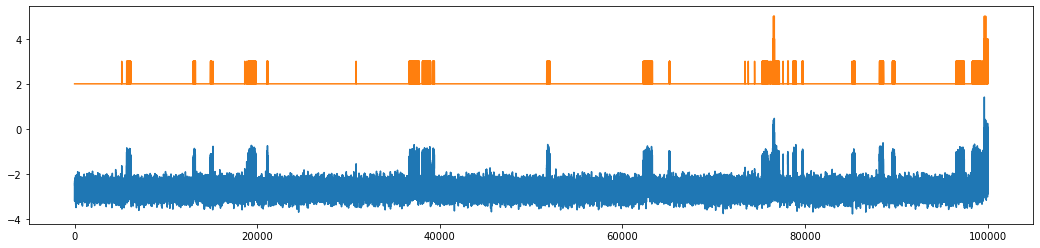

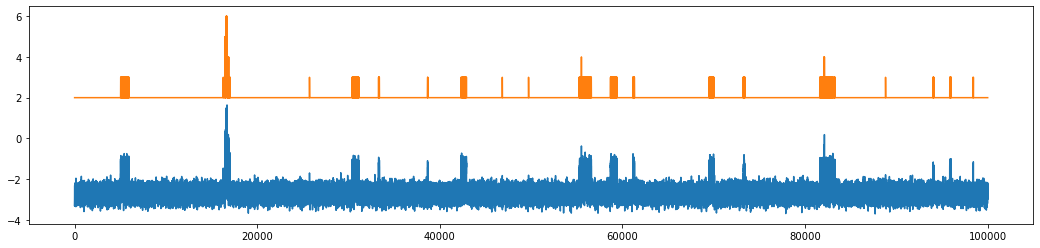

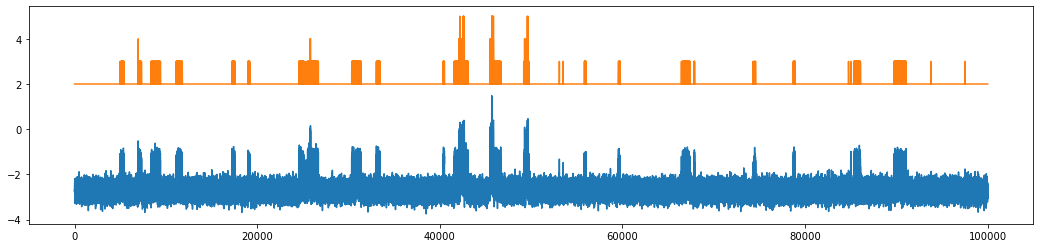

In [29]:
for x,p in zip(np.split(test.signal.values,20), np.split(preds_t,20)):
    plt.figure(figsize=(18, 4))
    plt.plot(x);
    plt.plot(p+2);

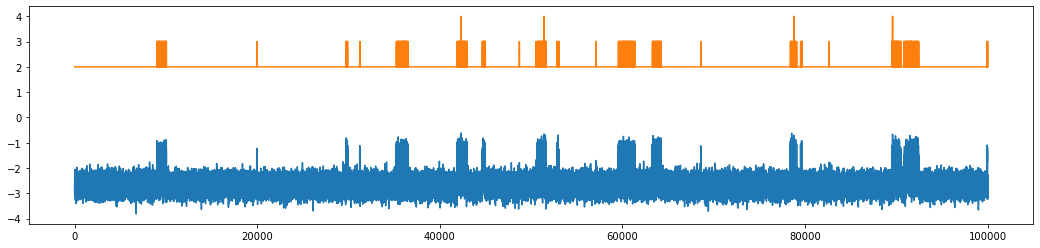

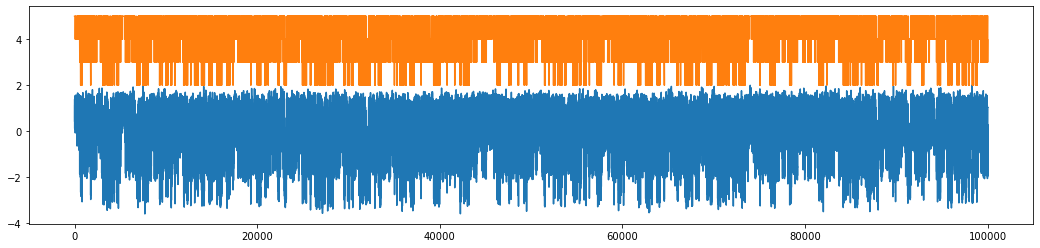

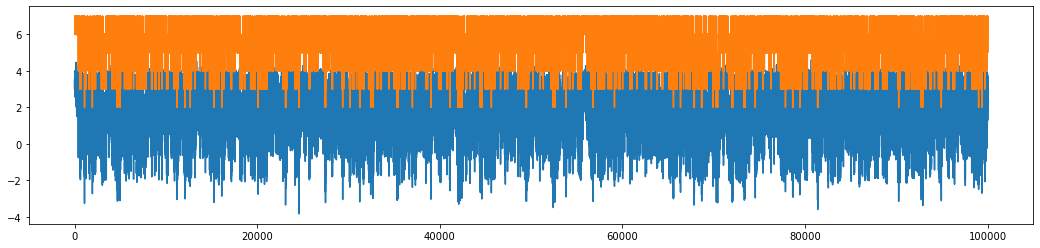

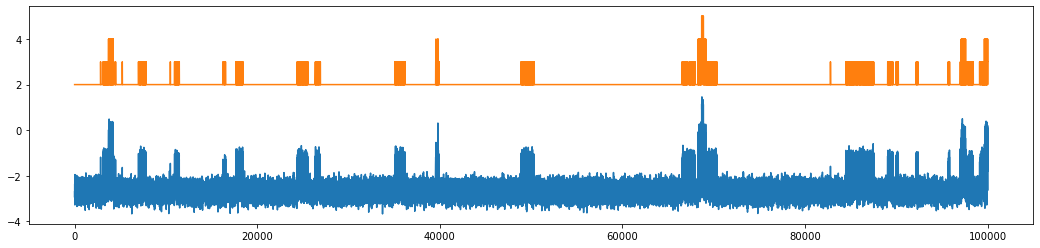

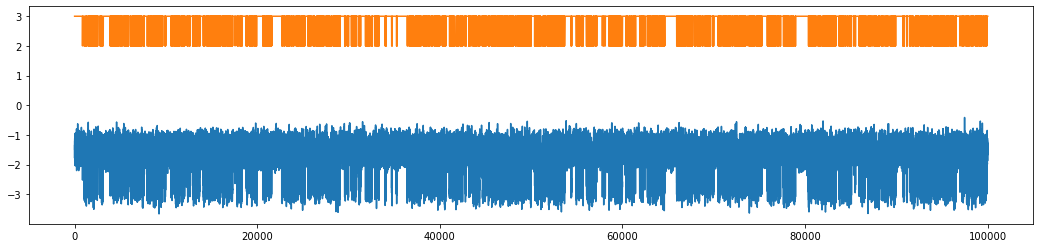

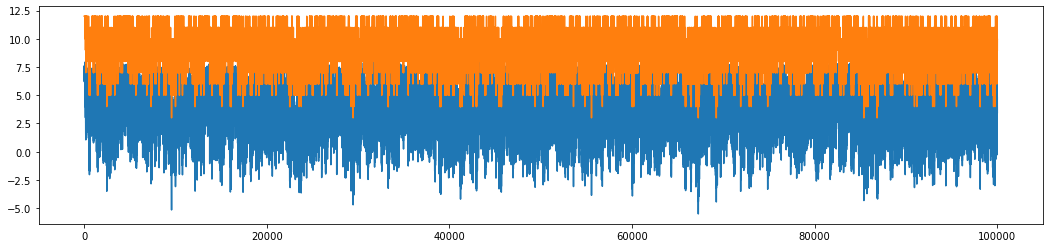

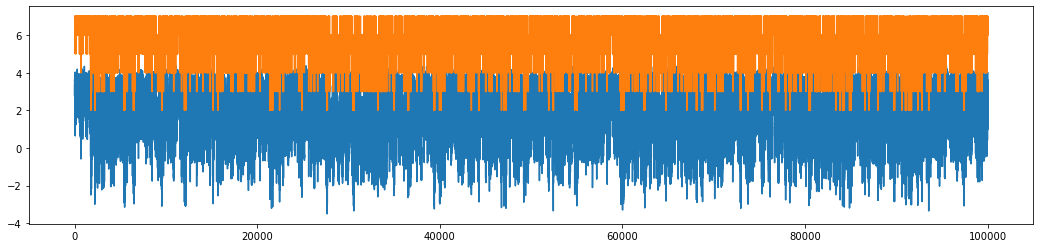

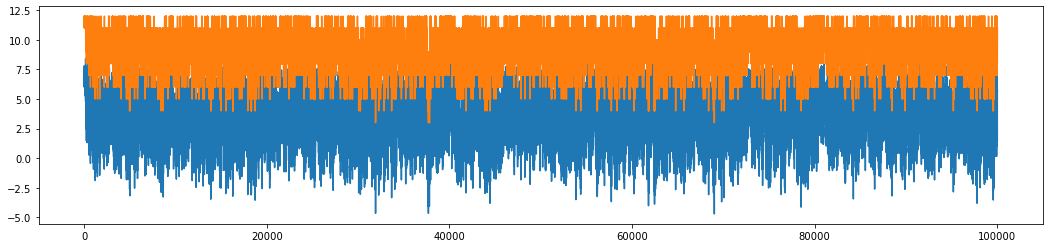

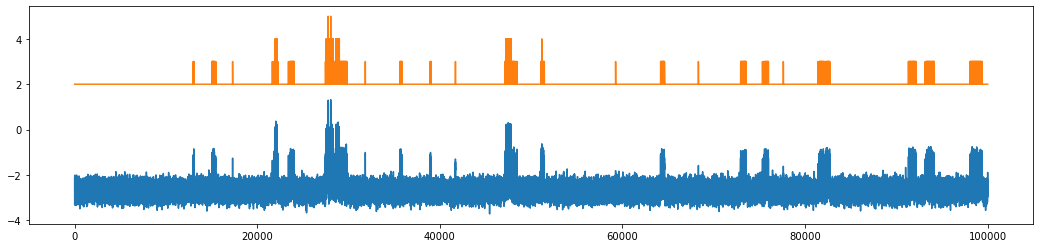

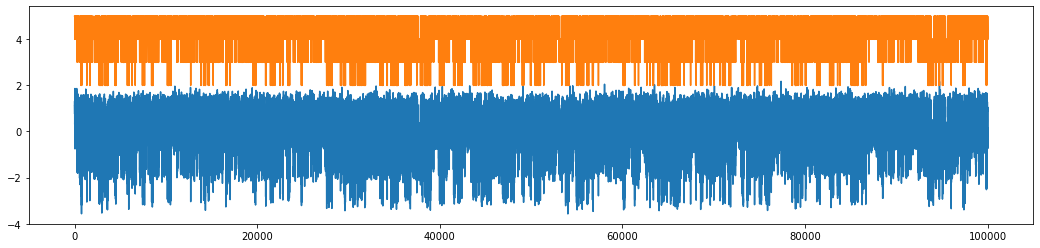

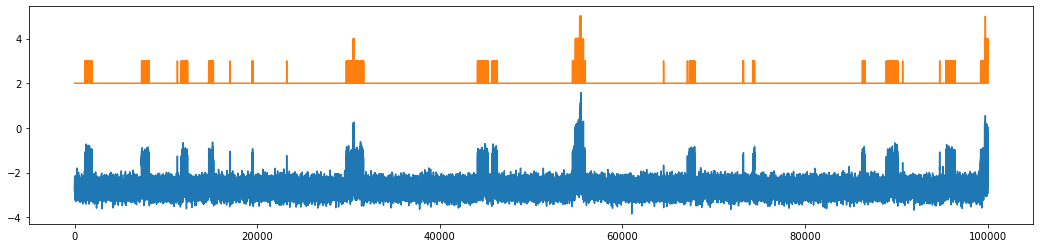

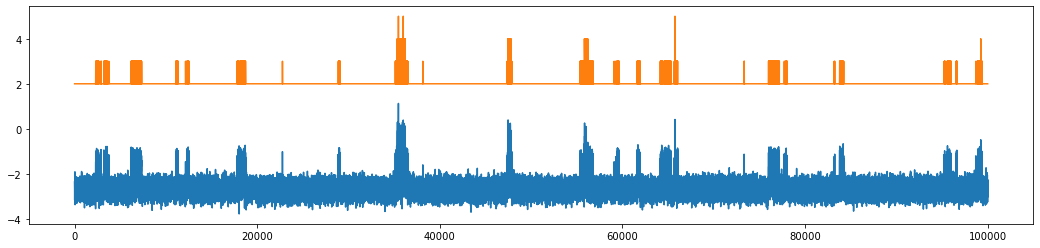

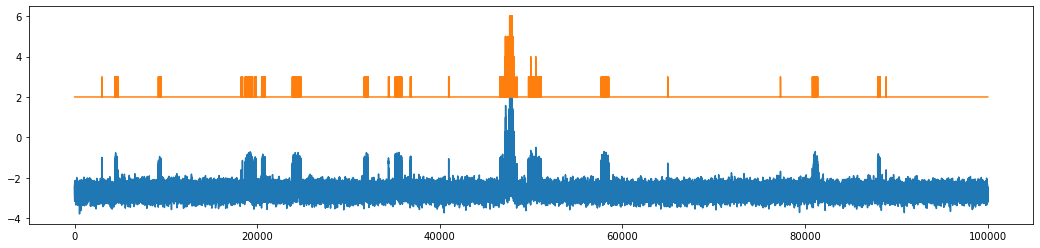

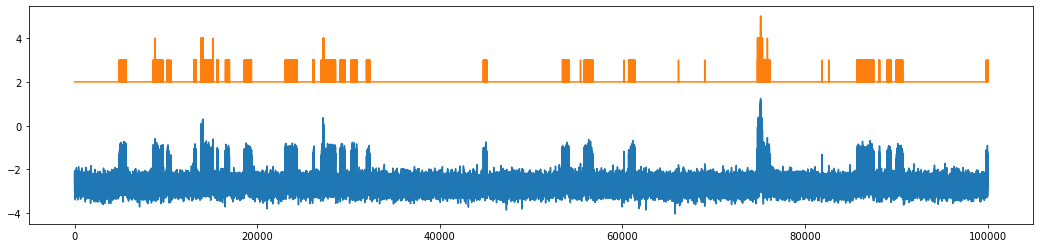

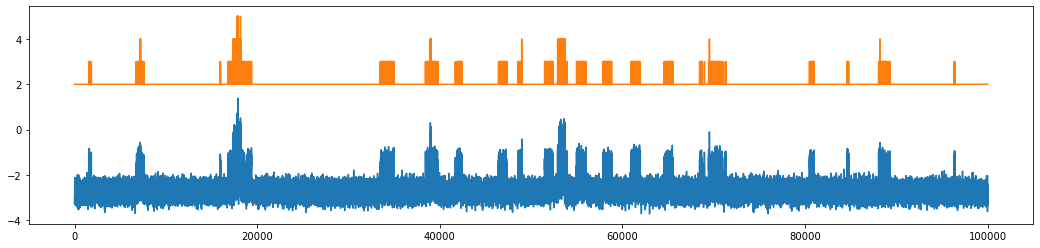

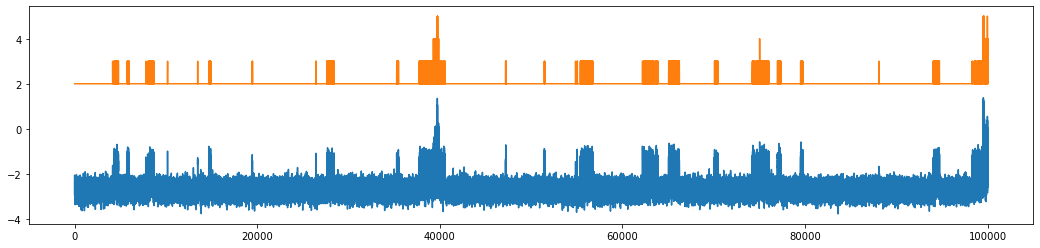

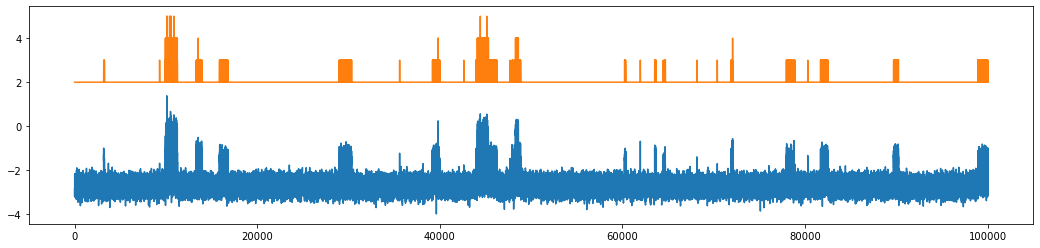

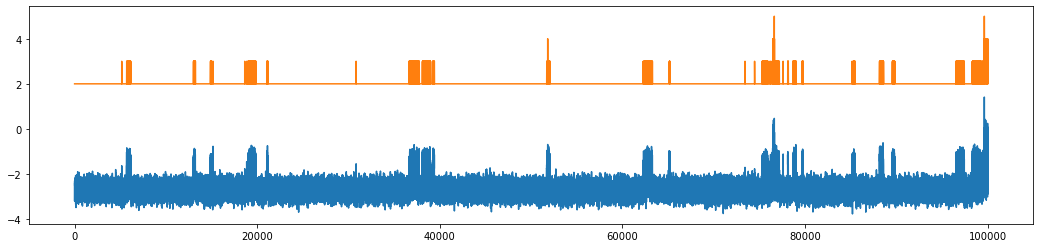

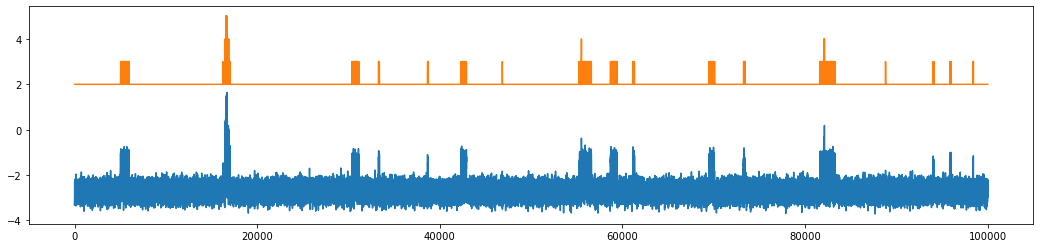

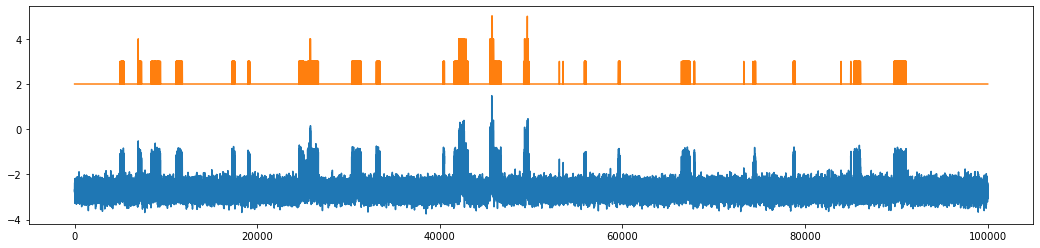

In [19]:
for x,p in zip(np.split(test.signal.values,20), np.split(preds_t,20)):
    plt.figure(figsize=(18, 4))
    plt.plot(x);
    plt.plot(p+2);

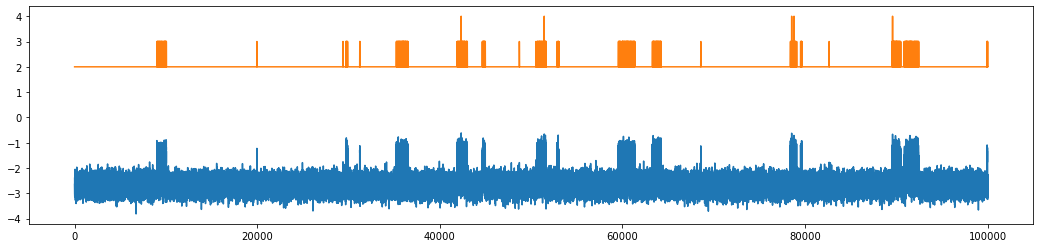

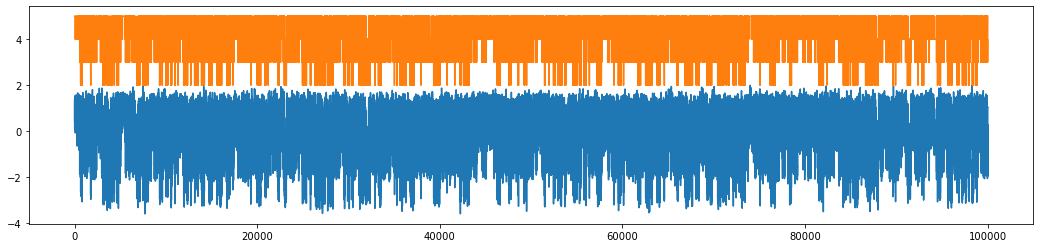

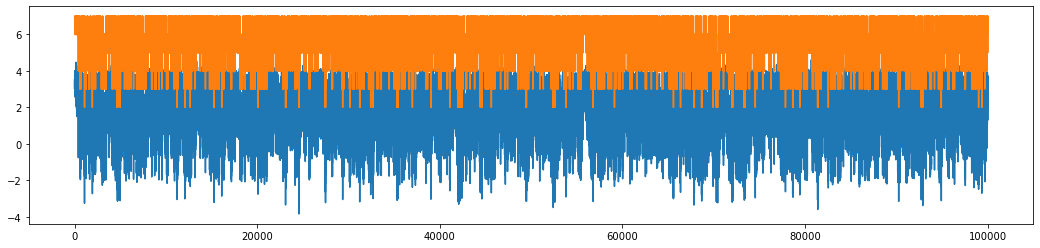

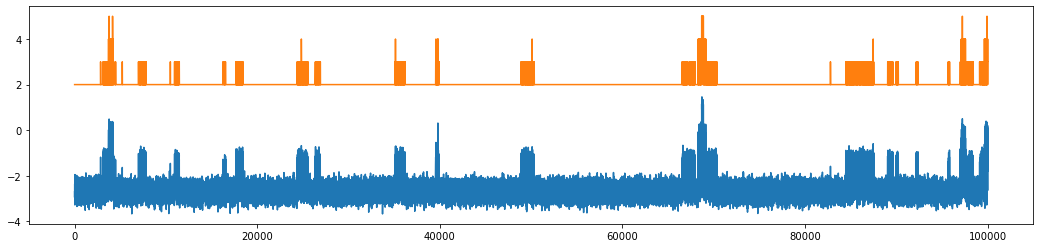

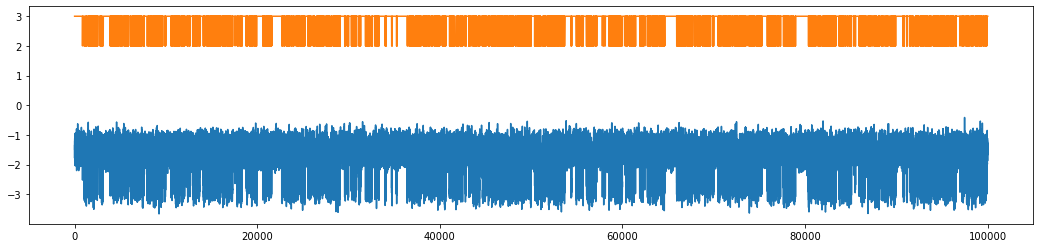

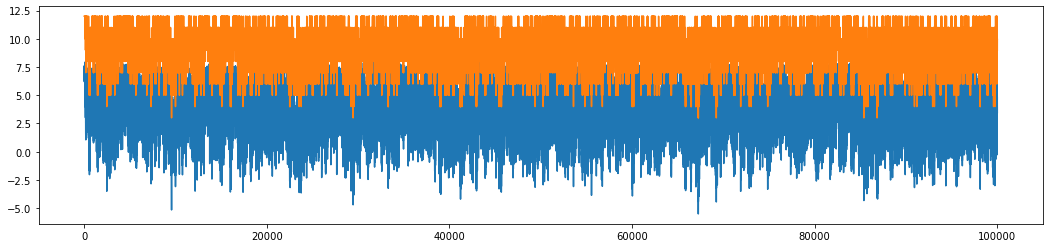

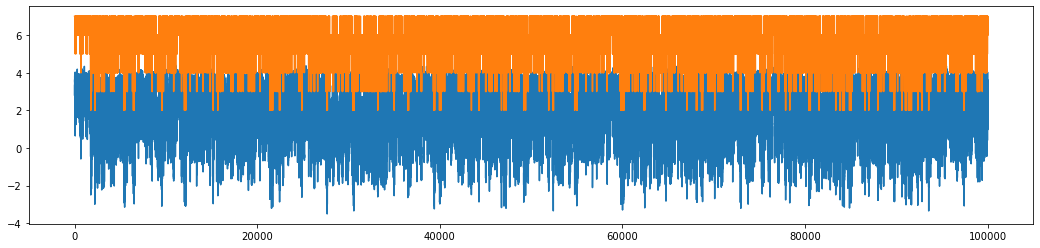

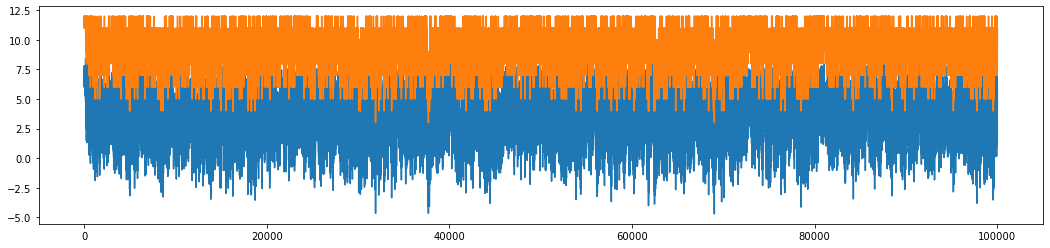

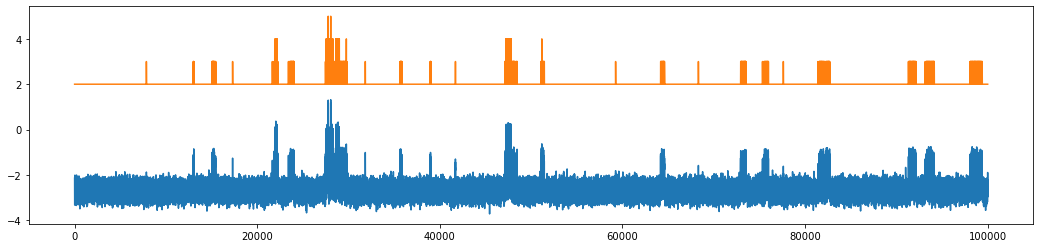

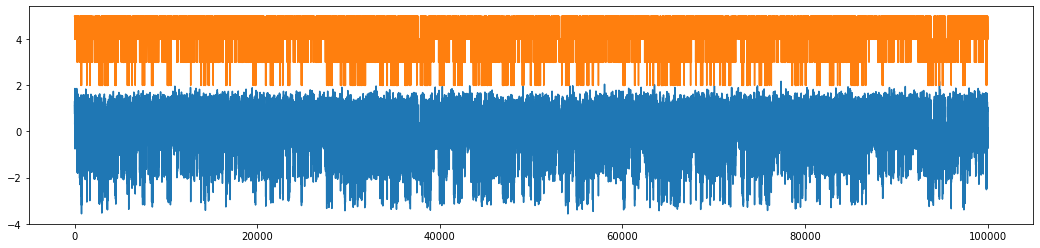

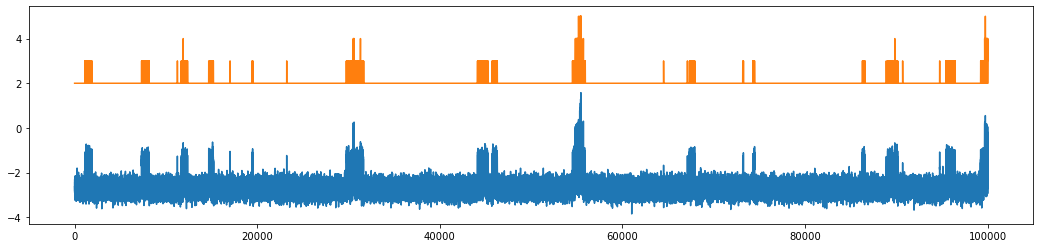

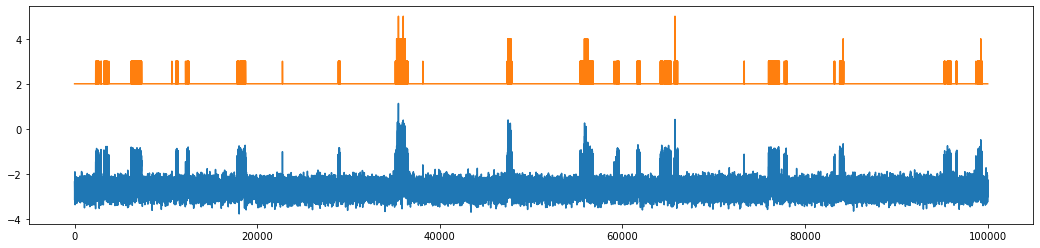

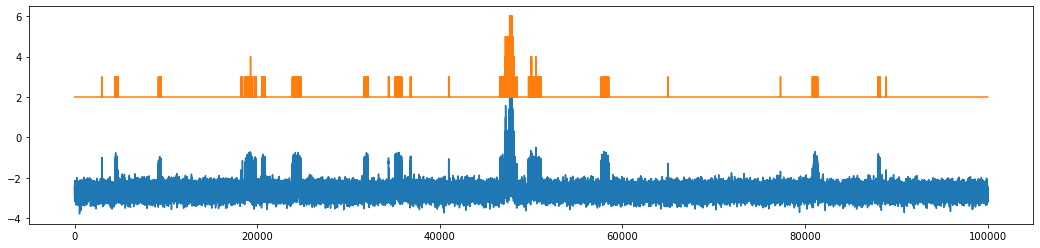

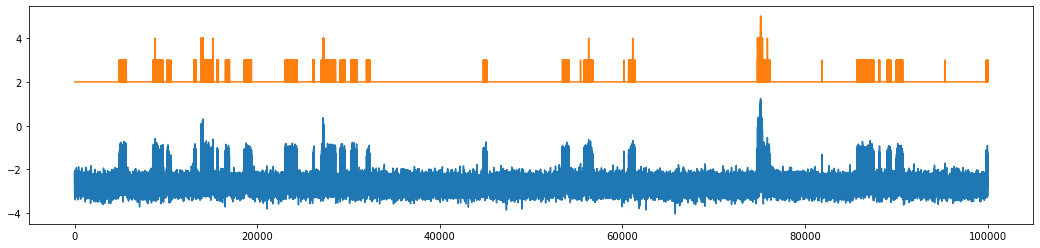

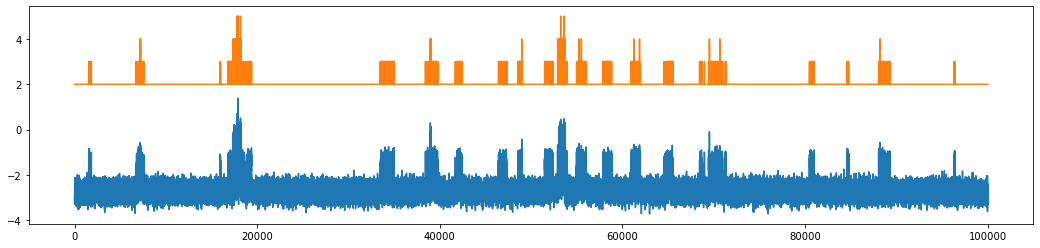

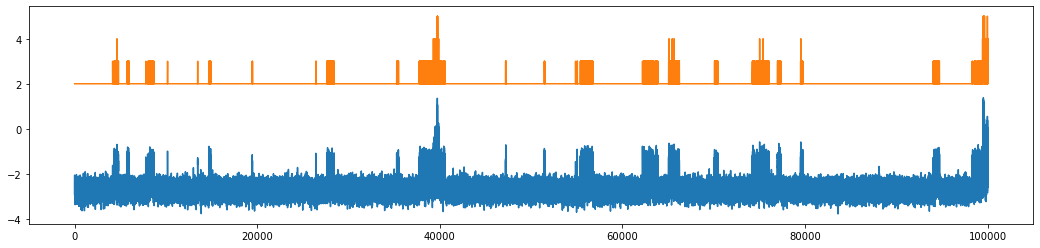

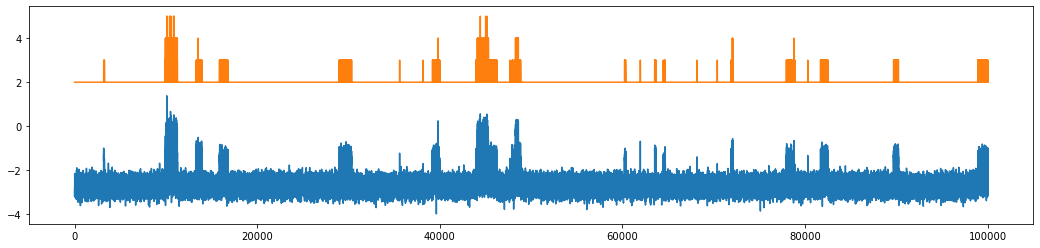

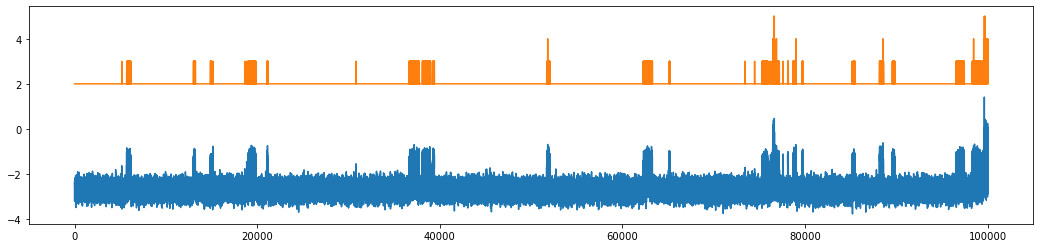

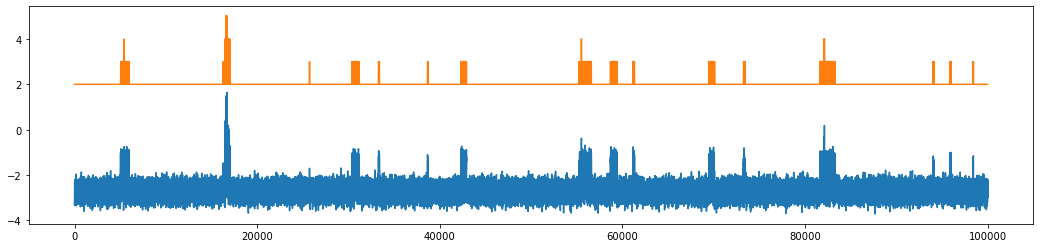

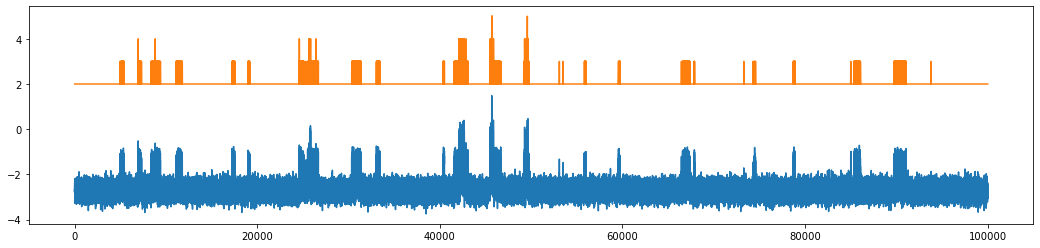

In [49]:
for x,p in zip(np.split(test.signal.values,20), np.split(preds_t,20)):
    plt.figure(figsize=(18, 4))
    plt.plot(x);
    plt.plot(p+2);

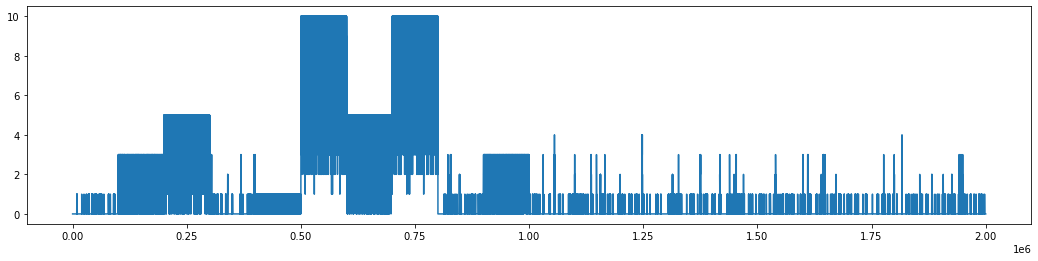

In [30]:
plt.figure(figsize=(18, 4))
plt.plot(preds_t);

In [31]:
sub["open_channels"] = preds_t
sub

,time,open_channels
0,500.000092,0
1,500.000214,0
2,500.000305,0
3,500.000397,0
4,500.000488,0
...,...,...
1999995,699.999573,0
1999996,699.999695,0
1999997,699.999817,0
1999998,699.999878,0


In [21]:
sub["open_channels"].mean()

1.379783

In [33]:
sub.to_csv("subs/net9_HIST_50hz_dsALL_AUG.csv", index=False, float_format="%.4f")

In [23]:
! head -n 12 "subs/net9_x&50hz&ALL_newdl.csv"

time,open_channels
500.0001,0
500.0002,0
500.0003,0
500.0004,0
500.0005,0
500.0006,0
500.0007,0
500.0008,0
500.0009,0
500.0010,0
500.0011,0


In [37]:
! head -n 12 data/sample_submission.csv

time,open_channels
500.0001,0
500.0002,0
500.0003,0
500.0004,0
500.0005,0
500.0006,0
500.0007,0
500.0008,0
500.0009,0
500.0010,0
500.0011,0


# Log


- Params
  - train: [0,2,7,5,9]
  - valid: [1,6,3,8,4]
  - BatchSize: 4000
  - Epochs: 3
  - Time E: 02:26
  - LR: 0.01
  - Loss: CE
  - Class Weigths: No
- Run 1
  - Gr 1 F1 0.9960806900290803
  - Gr 2 F1 0.9963459588420289
  - Gr 3 F1 0.9848021867504615
  - Gr 4 F1 0.9710975308321843
  - Gr 5 F1 0.7341472785857227
  - Mio: **0.9390239**
  - Kaggle: **0.939**
- Run 2
  - Gr 1 F1 0.9957449314364408
  - Gr 2 F1 0.9962454423859943
  - Gr 3 F1 0.9843876249290537
  - Gr 4 F1 0.9716066765153251
  - Gr 5 F1 0.7842656523598383
  - Mio: **0.938917**

In [4]:
len = 9
torch.linspace(start=1/len, end=1, steps=len).view(-1, len) * torch.ones([len,len])

tensor([[0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889, 1.0000],
        [0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889, 1.0000],
        [0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889, 1.0000],
        [0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889, 1.0000],
        [0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889, 1.0000],
        [0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889, 1.0000],
        [0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889, 1.0000],
        [0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889, 1.0000],
        [0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889, 1.0000]])

In [4]:
torch.linspace(start=0, end=1, steps=len).view(len, -1) * torch.ones([len,len])

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429],
        [0.2857, 0.2857, 0.2857, 0.2857, 0.2857, 0.2857, 0.2857, 0.2857],
        [0.4286, 0.4286, 0.4286, 0.4286, 0.4286, 0.4286, 0.4286, 0.4286],
        [0.5714, 0.5714, 0.5714, 0.5714, 0.5714, 0.5714, 0.5714, 0.5714],
        [0.7143, 0.7143, 0.7143, 0.7143, 0.7143, 0.7143, 0.7143, 0.7143],
        [0.8571, 0.8571, 0.8571, 0.8571, 0.8571, 0.8571, 0.8571, 0.8571],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]])

In [5]:
torch.linspace(start=1/len, end=1, steps=len).view(len, -1).expand(-1, len)

tensor([[0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111],
        [0.2222, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222],
        [0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333],
        [0.4444, 0.4444, 0.4444, 0.4444, 0.4444, 0.4444, 0.4444, 0.4444, 0.4444],
        [0.5556, 0.5556, 0.5556, 0.5556, 0.5556, 0.5556, 0.5556, 0.5556, 0.5556],
        [0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667],
        [0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778],
        [0.8889, 0.8889, 0.8889, 0.8889, 0.8889, 0.8889, 0.8889, 0.8889, 0.8889],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]])

In [6]:
torch.linspace(start=1/len, end=1, steps=len).view(-1, len).expand(len, -1)

tensor([[0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889, 1.0000],
        [0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889, 1.0000],
        [0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889, 1.0000],
        [0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889, 1.0000],
        [0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889, 1.0000],
        [0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889, 1.0000],
        [0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889, 1.0000],
        [0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889, 1.0000],
        [0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889, 1.0000]])